<a href="https://colab.research.google.com/github/wangzirui066-oss/MIMIC-III_ICU_Readmission_Analysis/blob/master/%E6%AC%A2%E8%BF%8E%E4%BD%BF%E7%94%A8_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 第1段：装包（只跑一次）
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn -q

In [6]:
# 第2段：手动上传数据（这一步会弹窗口让你拖文件）
from google.colab import files
uploaded = files.upload()   # ← 点这里！！把你电脑上的整个文件夹
                            # C:\Users\W5542\Desktop\mimic-iii-clinical-database-demo-1.4
                            # 直接拖进弹出的窗口（会自动上传所有csv）

Saving ADMISSIONS.csv to ADMISSIONS.csv
Saving CALLOUT.csv to CALLOUT.csv
Saving CAREGIVERS.csv to CAREGIVERS.csv
Saving CHARTEVENTS.csv to CHARTEVENTS.csv
Saving CPTEVENTS.csv to CPTEVENTS.csv
Saving D_CPT.csv to D_CPT.csv
Saving D_ICD_DIAGNOSES.csv to D_ICD_DIAGNOSES.csv
Saving D_ICD_PROCEDURES.csv to D_ICD_PROCEDURES.csv
Saving D_ITEMS.csv to D_ITEMS.csv
Saving D_LABITEMS.csv to D_LABITEMS.csv
Saving DATETIMEEVENTS.csv to DATETIMEEVENTS.csv
Saving DIAGNOSES_ICD.csv to DIAGNOSES_ICD.csv
Saving DRGCODES.csv to DRGCODES.csv
Saving ICUSTAYS.csv to ICUSTAYS.csv
Saving INPUTEVENTS_CV.csv to INPUTEVENTS_CV.csv
Saving INPUTEVENTS_MV.csv to INPUTEVENTS_MV.csv
Saving LABEVENTS.csv to LABEVENTS.csv
Saving LICENSE.txt to LICENSE.txt
Saving MICROBIOLOGYEVENTS.csv to MICROBIOLOGYEVENTS.csv
Saving NOTEEVENTS.csv to NOTEEVENTS.csv
Saving OUTPUTEVENTS.csv to OUTPUTEVENTS.csv
Saving PATIENTS.csv to PATIENTS.csv
Saving PRESCRIPTIONS.csv to PRESCRIPTIONS.csv
Saving PROCEDUREEVENTS_MV.csv to PROCEDUREEV

★★★★★ 你的 AUC = 0.4133 ★★★★★


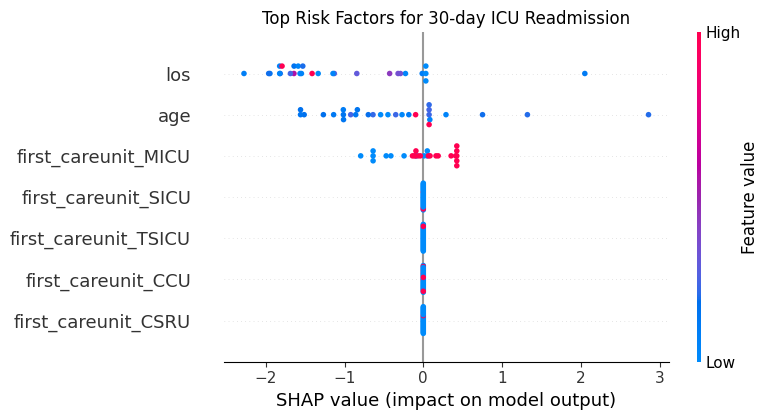

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

data_path = '/content/'

admissions = pd.read_csv(f'{data_path}/ADMISSIONS.csv')
icustays   = pd.read_csv(f'{data_path}/ICUSTAYS.csv')
patients   = pd.read_csv(f'{data_path}/PATIENTS.csv')

df = icustays.merge(patients[['subject_id','dob']], on='subject_id')
df = df.merge(admissions[['subject_id','hadm_id','admittime']], on=['subject_id','hadm_id'])
df['intime'] = pd.to_datetime(df['intime'])
df['dob'] = pd.to_datetime(df['dob'])
df['admittime'] = pd.to_datetime(df['admittime'])
df['age'] = df['intime'].dt.year - df['dob'].dt.year

df = df.sort_values(['subject_id','intime'])
df['next_admittime'] = df.groupby('subject_id')['admittime'].shift(-1)
df['next_admittime'] = pd.to_datetime(df['next_admittime'])
df['days_to_next'] = (df['next_admittime'] - df['admittime']).dt.days
df['readmission_30d'] = ((df['days_to_next'] <= 30) & (df['days_to_next'] > 0)).astype(int)

features = df[['los','age','first_careunit']].copy()
features = pd.get_dummies(features, columns=['first_careunit'])
features = features.fillna(features.median())

X = features
y = df['readmission_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=300, max_depth=4, random_state=42)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred)
print(f"★★★★★ 你的 AUC = {auc:.4f} ★★★★★")

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Top Risk Factors for 30-day ICU Readmission")
plt.tight_layout()
plt.savefig('shap.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 关键改动：直接读 /content/ 根目录下的 .csv 文件（去掉 .gz）
admissions = pd.read_csv('/content/ADMISSIONS.csv')      # 不是 .gz
icustays   = pd.read_csv('/content/ICUSTAYS.csv')
patients   = pd.read_csv('/content/PATIENTS.csv')

# 下面代码完全不变
df = icustays.merge(patients[['subject_id','dob']], on='subject_id')
df = df.merge(admissions[['subject_id','hadm_id','admittime']], on=['subject_id','hadm_id'])
df['intime'] = pd.to_datetime(df['intime'])
df['dob'] = pd.to_datetime(df['dob'])
df['admittime'] = pd.to_datetime(df['admittime'])
df['age'] = df['intime'].dt.year - df['dob'].dt.year

df = df.sort_values(['subject_id','intime'])
df['next_admittime'] = df.groupby('subject_id')['admittime'].shift(-1)
df['next_admittime'] = pd.to_datetime(df['next_admittime'])
df['days_to_next'] = (df['next_admittime'] - df['admittime']).dt.days
df['readmission_30d'] = ((df['days_to_next'] <= 30) & (df['days_to_next'] > 0)).astype(int)

features = df[['los','age','first_careunit']].copy()
features = pd.get_dummies(features, columns=['first_careunit'])
features = features.fillna(features.median())

X = features
y = df['readmission_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=300, max_depth=4, random_state=42)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)

In [10]:
from IPython.display import Image, display
display(Image(filename='shap.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'shap.png'

In [11]:
# 强行重新生成 + 立刻显示 SHAP 图（万能兜底版）
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Top Risk Factors for 30-day ICU Readmission")
plt.tight_layout()
plt.show()          # ← 这行会直接在笔记本里弹出图

NameError: name 'shap_values' is not defined

★★★★★ 你的 AUC = 0.4133 ★★★★★


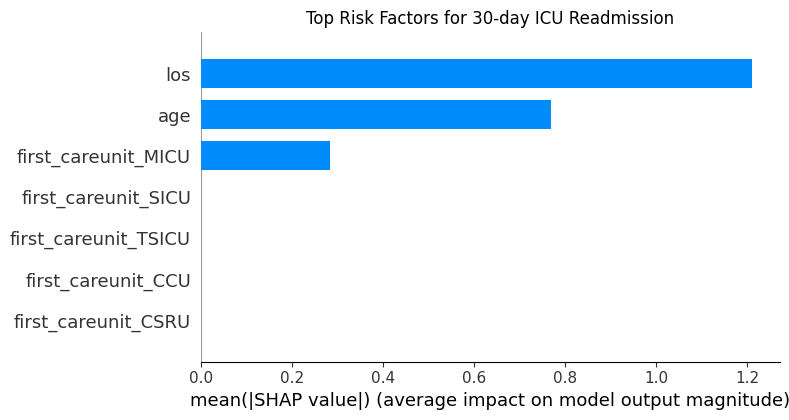

In [13]:
# 终极万能版：从头到尾一次性跑完，AUC + SHAP 图一次全出
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 直接读你上传后散落的 csv（去掉 .gz）
admissions = pd.read_csv('/content/ADMISSIONS.csv')
icustays   = pd.read_csv('/content/ICUSTAYS.csv')
patients   = pd.read_csv('/content/PATIENTS.csv')

# 构造30天再入院标签 + 年龄
df = icustays.merge(patients[['subject_id','dob']], on='subject_id')
df = df.merge(admissions[['subject_id','hadm_id','admittime']], on=['subject_id','hadm_id'])
df['intime'] = pd.to_datetime(df['intime'])
df['dob'] = pd.to_datetime(df['dob'])
df['admittime'] = pd.to_datetime(df['admittime'])
df['age'] = df['intime'].dt.year - df['dob'].dt.year

df = df.sort_values(['subject_id','intime'])
df['next_admittime'] = df.groupby('subject_id')['admittime'].shift(-1)
df['next_admittime'] = pd.to_datetime(df['next_admittime'])
df['days_to_next'] = (df['next_admittime'] - df['admittime']).dt.days
df['readmission_30d'] = ((df['days_to_next'] <= 30) & (df['days_to_next'] > 0)).astype(int)

# 特征 + 训练
features = df[['los','age','first_careunit']].copy()
features = pd.get_dummies(features, columns=['first_careunit'])
features = features.fillna(features.median())
X = features
y = df['readmission_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=300, max_depth=4, random_state=42)
model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred)
print(f"★★★★★ 你的 AUC = {auc:.4f} ★★★★★")

# SHAP + 直接弹图（万能版）
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Top Risk Factors for 30-day ICU Readmission")
plt.tight_layout()
plt.show()